# MODIS Open Question Exploration (v2.0)
Casey A Graff

August 23th, 2017

**Expanded confidence and FRP exploration using spatial maps.**

In [61]:
REP_DIR = '/home/graffc/extra/fire_prediction/'
SRC_DIR = REP_DIR + 'src/'
DATA_DIR = REP_DIR + 'data/'

# Load system-wide packages
import os
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import cumfreq
from scipy.stats.stats import pearsonr
import datetime as dt
import pytz
%matplotlib inline

# Load project packages
os.chdir(SRC_DIR)
from features.loaders import load_modis_df
from helper import date_util as du
from visualization.mapping import make_map
from helper.geometry import get_default_bounding_box

plt.rcParams['figure.figsize'] = [15,7]

In [2]:
# Load data
modis_df = load_modis_df(os.path.join(DATA_DIR, 'interim/modis/fire/fire_modis_alaska_2007-2016.pkl'))

In [3]:
# Add local_time column to modis_df
modis_df = modis_df.assign(datetime_local=map(lambda x: du.utc_to_local_time(x[0], x[1], du.round_to_nearest_quarter_hour), zip(modis_df.datetime_utc, modis_df.lon)))

In [4]:
modis_df[:5]

,datetime_utc,sat,lat,lon,T21,T31,sample,FRP,conf,type,datetime_local
0,2007-05-01 22:19:00+00:00,T,64.808,-147.609,302.6,291.1,1108,7.1,24,0,2007-05-01 12:34:00-09:45
1,2007-05-17 22:33:00+00:00,A,60.046,-151.492,314.1,289.3,813,13.3,53,0,2007-05-17 12:33:00-10:00
2,2007-05-19 23:44:00+00:00,T,67.019,-158.293,301.4,291.3,1233,23.8,43,0,2007-05-19 13:14:00-10:30
3,2007-05-21 20:16:00+00:00,T,62.808,-138.762,302.0,289.6,316,4.5,35,0,2007-05-21 11:01:00-09:15
4,2007-05-21 22:09:00+00:00,A,63.922,-146.422,321.6,292.9,716,16.8,81,0,2007-05-21 12:24:00-09:45


## Timing of satellite measurements

At what times of the day do the satellites fly over Alaska (in local time)? Is it evenly spaced, as is expected at the equator? Is there a significant difference in day/night detections? Is there a difference between the north/south of alaska?

### Temporal distribution of detections


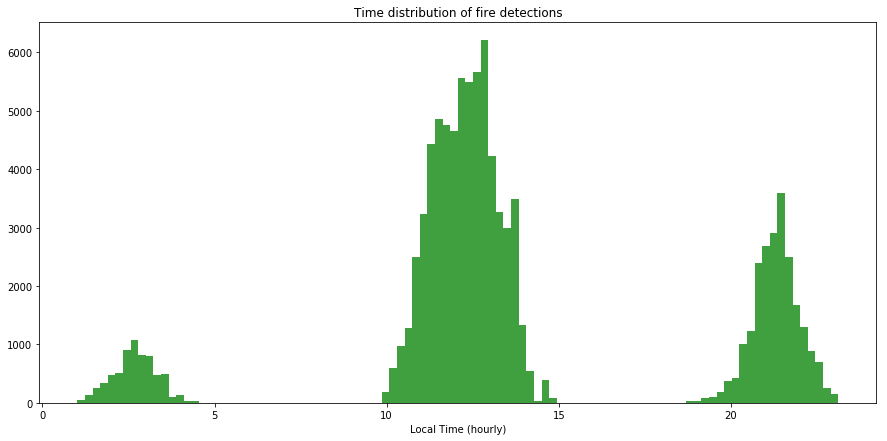

In [62]:
def dt_to_hours_frac(dt):
    return dt.hour + (dt.minute / 60.)

# Plot a histogram of the times of measurements across all of Alaska


times = map(dt_to_hours_frac, modis_df.datetime_local)

_ = plt.hist(times, 100, facecolor='green', alpha=.75)
_ = plt.title('Time distribution of fire detections')
_ = plt.xlabel('Local Time (hourly)')

There are substantially fewer detections in the evening and early morning passes as compared to mid-day. However, there are only three groupings which suggests that the two satellites are overlapping during a time-period (most likely mid-day).

### Temporal distribution of detections (separated by satellite)

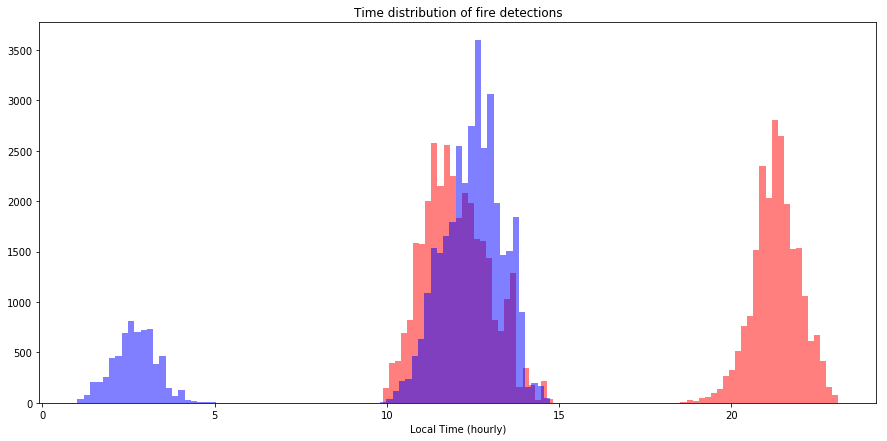

In [63]:
# Plot a histogram of the times of measurements across all of Alaska (Aqua vs Terra)
times_terra = map(dt_to_hours_frac, modis_df[modis_df.sat=='T'].datetime_local)
times_aqua = map(dt_to_hours_frac, modis_df[modis_df.sat=='A'].datetime_local)

_ = plt.hist(times_terra, 75, facecolor='red', alpha=.5)
_ = plt.hist(times_aqua, 75, facecolor='blue', alpha=.5)
_ = plt.title('Time distribution of fire detections')
_ = plt.xlabel('Local Time (hourly)')

### Examine Overlap Within a Date Range

In [ ]:
start_date, end_date = dt.datetime(2013,6,1, tzinfo=pytz.UTC), dt.datetime(2013,6,30, tzinfo=pytz.UTC)

# Plot a histogram of the times of measurements across all of Alaska (Aqua vs Terra)
sel_df = modis_df[(modis_df.datetime_local >= start_date) & (modis_df.datetime_local <= end_date)]
times_terra = map(dt_to_hours_frac, sel_df[sel_df.sat=='T'].datetime_local)
times_aqua = map(dt_to_hours_frac, sel_df[sel_df.sat=='A'].datetime_local)

_ = plt.hist(times_terra, 75, facecolor='red', alpha=.5)
_ = plt.hist(times_aqua, 75, facecolor='blue', alpha=.5)
_ = plt.title('Time distribution of fire detections')
_ = plt.xlabel('Local Time (hourly)')

 The orbits of Aqua and Terra overlap in the mid-day. We see that the the satellites usually fly over at approximately 2:30 a.m., 11:00 a.m., 1 p.m. and 9 p.m. (local time). 

If the satellites are "double-counting" fire pixels during their overlap, then the drop-off in detections between mid-day and evening are much smaller than orignally thought. However, the drop-off into early morning is still significant.

### Temporal distribution of detections (separated by satellite & northern latitude)

In [ ]:
ALASKA_BB = get_default_bounding_box()

# Calculate lat midpoint
lat_min, lat_max, _, _ = ALASKA_BB.get()
lat_midpoint = (lat_min + lat_max) / 2.

# Filter only northern Alaska
modis_df_north = modis_df[modis_df.lat > lat_midpoint]

print 'Comprises {:.2f}% of total data'.format(len(modis_df_north)/(.01 * len(modis_df)))

# Plot a histogram of the times of measurements in only northern Alaska (Aqua vs Terra
times_terra = map(dt_to_hours_frac, modis_df_north[modis_df_north.sat=='T'].datetime_local)
times_aqua = map(dt_to_hours_frac, modis_df_north[modis_df_north.sat=='A'].datetime_local)

_ = plt.hist(times_terra, 75, facecolor='red', alpha=.5)
_ = plt.hist(times_aqua, 75, facecolor='blue', alpha=.5)
_ = plt.title('Time distribution of fire detections in northern Alaska')
_ = plt.xlabel('Local Time (hourly)')

The difference between all of Alaska and just the northern half is minimal because it comprises 85% of all fire detections. It is difficult to determine if there is a significant shift in the overlap closer to the pole.

### Temporal distribution of detections (separated by satellite & southern latitude)

In [ ]:
# Filter only southern Alaska
modis_df_south = modis_df[modis_df.lat < lat_midpoint]

print 'Comprises {:.2f}% of total data'.format(len(modis_df_south)/(.01 * len(modis_df)))

# Plot a histogram of the times of measurements in only southern Alaska (Aqua vs Terra
times_terra = map(dt_to_hours_frac, modis_df_south[modis_df_south.sat=='T'].datetime_local)
times_aqua = map(dt_to_hours_frac, modis_df_south[modis_df_south.sat=='A'].datetime_local)

_ = plt.hist(times_terra, 75, facecolor='red', alpha=.5)
_ = plt.hist(times_aqua, 75, facecolor='blue', alpha=.5)
_ = plt.title('Time distribution of fire detections in southern Alaska')
_ = plt.xlabel('Local Time (hourly)')

### Night vs Day Detections

In [ ]:
times = map(dt_to_hours_frac, modis_df.datetime_local)
day_times = [t for t in times if t>10 and t<15]
print 'Percentage of day detctions: {:.4}%'.format(len(day_times)/float(len(times))*100)

There is slightly more noticeable separation in the mid-day, but still seems rather minimal.

## Confidence

Can the confidence metric be used to throw-out likely false-alarms or to weight detections? Is there sufficient variance in the metric to be worth considering (or are most values very high)?

According to Giglio et al. 2003 the confidence is the geometric mean of the following five sub-confidences (each sub-confidence is smoothed to [0, 1]).

* C(1) = temperature of the pixel in the 4um channel (T_4)
* C(2) = mean absolute deviation of T_4 relative to "background"
* C(3) = mean absolute deviation of T_4 - T_11 relative to "background"
* C(4) = decreases based on number of adjacent pixels covered in clouds
* C(5) = decreases based on number of adjacent pixels that are water

In [ ]:
print 'Percent of conf ==100 is {}%'.format(sum(modis_df.conf==100) / (.01 * len(modis_df)))
print 'Percent of conf >=66 is {}%'.format(sum(modis_df.conf>=66) / (.01 * len(modis_df)))
print 'Percent of conf >=50 is {}%'.format(sum(modis_df.conf>=50) / (.01 * len(modis_df)))
print 'Percent of conf >=33 is {}%'.format(sum(modis_df.conf>=33) / (.01 * len(modis_df)))
print 'Percent of conf ==0 is {}%'.format(sum(modis_df.conf==0) / (.01 * len(modis_df)))

# Plot histogram
_, ax1 = plt.subplots()
_ = ax1.hist(modis_df.conf, 100, facecolor='blue', alpha=.5)
_ = plt.title('Confidence distribution')
_ = plt.xlabel('Confidence (0 to 100)')

# Plot "CDF" line
ax2 = ax1.twinx()
CY, _, _, _ = cumfreq(list(modis_df.conf), 100)
_ = ax2.plot(CY/CY[-1])

There is a substantial ammount of variance in the confidence. About 15% of the data falls below 50% confidence and there is a reasonable number (3%) of confidences that are equal to 0%. 

Further investigation into the spatial distribution of the confidence may be insightful. It is possible that lower confidence predictions occure primarily arround the coast or mountain where there are more adjacent water or cloud pixels. 

### Spatial Distribution of Confidence

In [50]:
b = np.array(map(lambda x: x.year, np.array(modis_df.datetime_local)))==2007
c = np.array(map(lambda x: x.dayofyear, np.array(modis_df.datetime_local)))==241
d = np.array(map(lambda x: x.dayofyear, np.array(modis_df.datetime_local)))<241
b = b & c

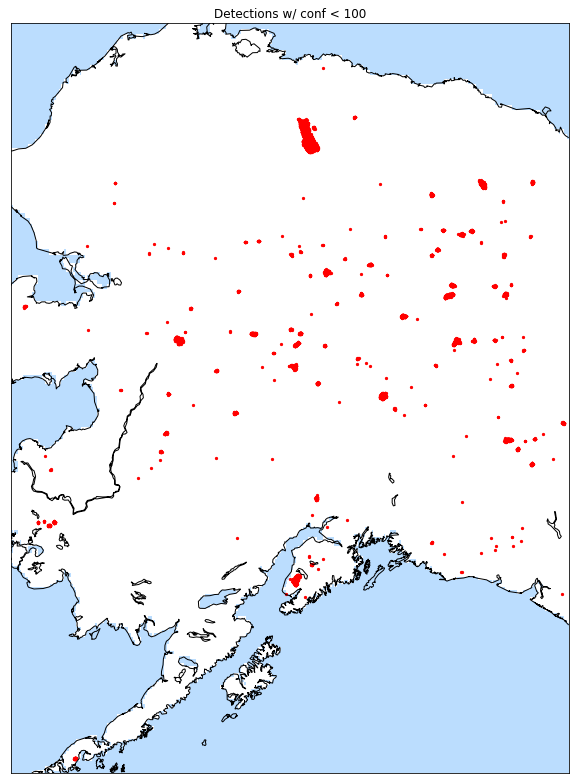

In [204]:
import visualization.mapping as vmap
reload(vmap)
ALASKA_BB = get_default_bounding_box()
plt.rcParams['figure.figsize'] = [10,15]

mp = vmap.make_map(ALASKA_BB, (0,0,0,0))
mp.drawlsmask(land_color='w', ocean_color=(30./256,144./256,255./256,.3))

sel_df = modis_df[b]
_ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 5, latlon=True, marker='o', color='r')
_ = plt.title('Detections w/ conf < %d' % CONF_THRESH)

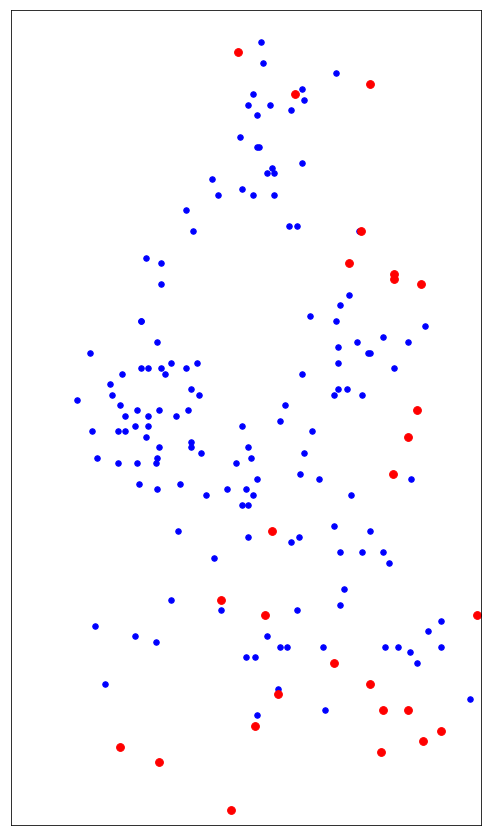

In [58]:
import visualization.mapping as vmap
from helper.geometry import LatLonBoundingBox
reload(vmap)
sel_BB = LatLonBoundingBox(68.97,69.125,-150.9,-150.65)
plt.rcParams['figure.figsize'] = [10,15]

mp = vmap.make_map(sel_BB, (0,0,0,0))

sel_df = modis_df[b]
sel_df2 = modis_df[d]
_ = mp.scatter(list(sel_df2.lon), list(sel_df2.lat), 30, latlon=True, marker='o', color='b')
_ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 60, latlon=True, marker='o', color='r')
#_ = plt.title('Detections w/ conf < %d' % CONF_THRESH)

In [156]:
print modis_df[b].datetime_local.iloc[1000]

2007-07-04 11:12:00-09:45


In [123]:
start = modis_df[b].datetime_local[316]
end = modis_df[b].datetime_local[317]

#sel_df = modis_df[b & (modis_df.datetime_local>=start) & (modis_df.datetime_local<=end)]
sel_df = modis_df[modis_df.datetime_local<=end]
print start, end
print sel_df

2007-05-30 11:48:00-10:00 2007-05-31 12:31:00-10:15
                 datetime_utc sat     lat      lon    T21    T31  sample  \
0   2007-05-01 22:19:00+00:00   T  64.808 -147.609  302.6  291.1    1108   
1   2007-05-17 22:33:00+00:00   A  60.046 -151.492  314.1  289.3     813   
2   2007-05-19 23:44:00+00:00   T  67.019 -158.293  301.4  291.3    1233   
3   2007-05-21 20:16:00+00:00   T  62.808 -138.762  302.0  289.6     316   
4   2007-05-21 22:09:00+00:00   A  63.922 -146.422  321.6  292.9     716   
5   2007-05-21 22:09:00+00:00   A  63.919 -146.442  311.4  290.1     717   
6   2007-05-22 20:58:00+00:00   T  66.646 -149.651  313.6  275.0     254   
7   2007-05-23 06:40:00+00:00   T  66.637 -149.673  312.0  278.5     965   
8   2007-05-23 06:40:00+00:00   T  66.651 -149.660  305.1  277.8     964   
9   2007-05-23 06:40:00+00:00   T  66.646 -149.684  318.3  277.6     965   
10  2007-05-23 06:40:00+00:00   T  66.641 -149.708  302.9  276.4     966   
11  2007-05-23 08:18:00+00:00   T  6

2007-09-04 10:52:00-10:00 2007-09-11 12:36:00-10:00


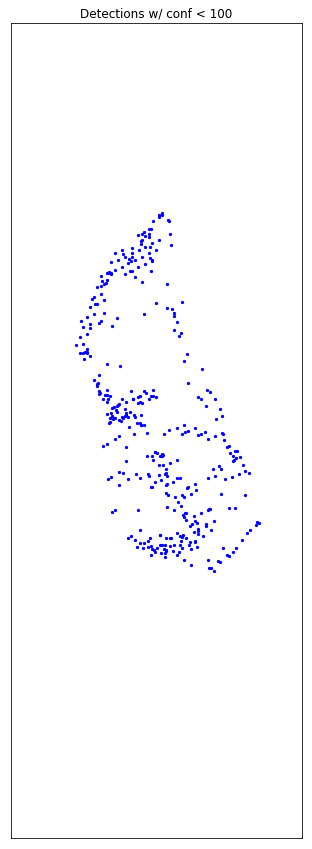

In [177]:
start = modis_df[b].datetime_local.iloc[4000]
end = modis_df[b].datetime_local.iloc[4500]

sel_BB = LatLonBoundingBox(68.6,69.6,-151.15,-150.15)
plt.rcParams['figure.figsize'] = [10,15]

mp = vmap.make_map(sel_BB, (0,0,0,0))

print start,end
sel_df1 = modis_df[b & (modis_df.datetime_local>=start) & (modis_df.datetime_local<=end)]
_ = mp.scatter(list(sel_df1.lon), list(sel_df1.lat), 5, latlon=True, marker='o', color='b')
_ = plt.title('Detections w/ conf < %d' % CONF_THRESH)

2007-09-10 12:10:00-10:00 2007-09-11 12:36:00-10:00


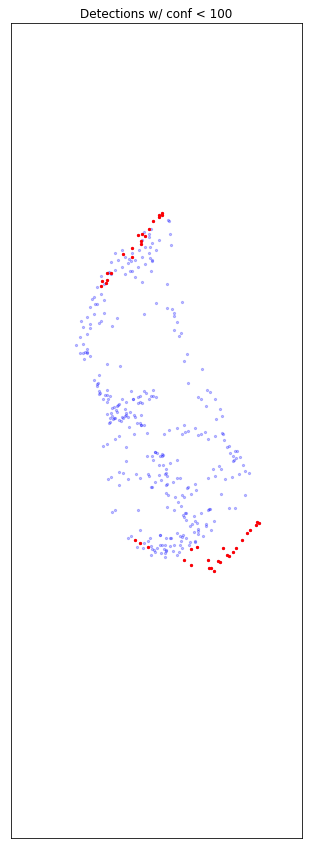

In [187]:
start = modis_df[b].datetime_local.iloc[4480]
end = modis_df[b].datetime_local.iloc[4502]

sel_BB = LatLonBoundingBox(68.6,69.6,-151.15,-150.15)
plt.rcParams['figure.figsize'] = [10,15]

mp = vmap.make_map(sel_BB, (0,0,0,0))

print start,end
sel_df = modis_df[b & (modis_df.datetime_local>=start) & (modis_df.datetime_local<=end)]
_ = mp.scatter(list(sel_df1.lon), list(sel_df1.lat), 5, latlon=True, marker='o', color='b', alpha=.25)
_ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 5, latlon=True, marker='o', color='r')
_ = plt.title('Detections w/ conf < %d' % CONF_THRESH)

In [ ]:
CONF_THRESH = 32

plt.rcParams['figure.figsize'] = [10,15]

mp = make_map(ALASKA_BB)
mp.shadedrelief()

sel_df = modis_df[modis_df.conf <= CONF_THRESH]
_ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 5, latlon=True, marker='o', color='b')
_ = plt.title('Detections w/ conf < %d' % CONF_THRESH)

In [ ]:
CONF_THRESH = 0

plt.rcParams['figure.figsize'] = [10,15]

mp = make_map(ALASKA_BB)
mp.shadedrelief()

sel_df = modis_df[modis_df.conf <= CONF_THRESH]
_ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 5, latlon=True, marker='o', color='b')
_ = plt.title('Detections w/ conf < %d' % CONF_THRESH)

The low confidence detections doesn't seem to have an obvious pattern (e.g. all along the coast). Perhaps the low confidences are a result of cloud coverage and may be correlated with rain. 

## Fire Radiated Power

How much does the FRP vary for fire pixels? Can it be used as a feature (or a target variable)? Is there a high correlation between FRP and confidence?

### FRP Variance

In [ ]:
# Plot a histogram of the times of measurements across all of Alaska
print 'Precent of FRP >=500 is {}%'.format(sum(modis_df.FRP>=500)/(.01 * len(modis_df)))
print 'Max value of FRP is {}'.format(max(modis_df.FRP))
print 'Mean value of FRP is {}'.format(np.mean(modis_df.FRP))
_ = plt.hist(modis_df.FRP, 200, range=(0,500), facecolor='green', alpha=.75)
_ = plt.title('Distribution of fire radiated power (FRP)')
_ = plt.xlabel('FRP (MW)')

The FRP varies significantly (with some values going over 5000) while most fall into the range of 0 to 100 MW. If these values are reliable (and the wide range isn't attributable to some sensor issue) then this may be useful in separating small fires (within a pixel) from larger. 

Does the FRP have more to do with the fuel that is burning (e.g. brush vs. house)?

It may worth investigating if higher temperatures are related to larger fire events. If so, is the larger event triggering a greater FRP or are higher FRP fire pixels more likely to spread? Perhaps the opposite could also be true, where a hot, isolated fire may have a large FRP because the calculation may use background pixels as a baseline. Information on how this is calculated would be useful.

## FRP Variance (log scale)

In [ ]:
# Plot a histogram of the times of measurements across all of Alaska
print 'Precent of FRP >=500 is {}%'.format(sum(modis_df.FRP>=500)/(.01 * len(modis_df)))
print 'Max value of FRP is {}'.format(max(modis_df.FRP))
_ = plt.hist(modis_df.FRP, bins=10 ** np.linspace(np.log10(.01), np.log10(500), 200), facecolor='green', alpha=.75)
_ = plt.title('Distribution of fire radiated power (FRP)')
_ = plt.xlabel('FRP (MW)')

### Correlation between FRP and confidence

In [ ]:
# Plot FRP vs conf
_ = plt.scatter(modis_df.conf, modis_df.FRP)
_ = plt.title('FRP vs confidence')
_ = plt.xlabel('Confidence (0 to 100)')
_ = plt.ylabel('FRP (MW)')

# Plot lin. regr. line
fit = np.polyfit(modis_df.conf, modis_df.FRP, 1)
fit_fn = np.poly1d(fit) 
_ = plt.plot(modis_df.conf, fit_fn(modis_df.conf), '--k')

pcc, _ = pearsonr(modis_df.conf, modis_df.FRP)
print 'Pearson correlation coefficient is {}'.format(pcc)

There seems to be a very loose positive trend between the confidence and FRP. The large cluster at zero confidence is now even more interesting because none of the nearby confidences have FRP values nearly as high as those found exactly at zero. This seems to suggest that at least some of these zero confidence fire detections were very abruptly brough to zero. 

## Fire Type
Is the fire type being used to remove all non-vegetation fires?

Previously, it was not. However, it is now being used (including the data above).

In [ ]:
old_num_detections = 96218
num_removed = old_num_detections - len(modis_df)
print 'Num of detections removed is {}'.format(num_removed)
print 'Percent of detections removed is {}%'.format(num_removed / (.01 * old_num_detections))

While we are now ignoring this non-vegetation fires, the ammount previously included was extremely small.

## Leap Year
Does the MODIS dataset include leap year in its date?

**Yes; however, no vegetation fire detections occured on leap day in Alaska between 2007 and 2016.**

In [ ]:
print 'Number of fire detections on Feb. 29th (leap day) is {}'.format(
    sum((modis_df.index.month==2) & (modis_df.index.day==29)))

In [ ]:
import helper.df_util as dfu

def get_date_range_list(X): 
    date_range=((5,14), (8,31))
    year_range = dfu.get_year_range(X, 'date_local')

    dates = []
    for year in range(year_range[0], year_range[1]+1):
        begin = dt.date(year, date_range[0][0], date_range[0][1])
        end = dt.date(year, date_range[1][0], date_range[1][1])

        dates += list(du.daterange(begin, end + du.INC_ONE_DAY))

    return dates
    
X = modis_df
X_ = X.assign(date_local=map(lambda x: du.utc_to_local_time(x[0], x[1], du.round_to_nearest_quarter_hour).date(), zip(X.datetime_utc, X.lon)))
date_range = get_date_range_list(X_)

In [ ]:
vals = []
for d in date_range:
    vals.append(len(X_[X_.date_local==d]))

In [ ]:
vals = np.array(vals)
plt.hist(vals, 100)
print np.mean(vals), np.var(vals)